# №2. Разведочный анализ данных, реализация скриптов для подготовки выборок

Проведение разведочного анализа включает в себя такие подзадачи как:
* частотный анализ коллекции (например: распределение количества слов в документах);
* выбор пространства признаков с обоснованием данных признаков;
* визуализация данных;
* подсчет статистических параметров для коллекции с использованием выбранных признаков (например: среднее, стандартное отклонение, квартили и т. д.);
* поиск выбросов и аномалий, их анализ, выбор методов детектирования аномалий и их обработки;
* корреляционный анализ (например: построенные парные диаграммы рассеяния различных признаков, их гистограммы распределения, корреляционные матрицы, проверка гипотезы о гомоскедастичности данных и подобных ей);
* выбор целевых переменных для задач классификации документов по темам на основе тегов и предсказания рейтинга документа;
* построение распределения и анализ целевых переменных.

Для полноты анализа могут быть описаны различные преобразования данных и их анализ, применение PCA, анализ feature importance, поиск ложных корреляций.

После проведения каждого анализа следует фиксировать выводы о полученных результатах. 

Для сдачи необходимо представить ноутбуки, в которых проведен соответствующий анализ и описаны выводы и рекомендации по работе с данной коллекцией.

In [450]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter

### Загрузка предобработанных данных 

In [265]:
PATH = "C:/Users/LADA/Inf_Search"

In [266]:
data_path = "{}/{}".format(PATH, "data")

In [267]:
data_file = 'data_without_stopwords.csv'

In [268]:
df = pd.read_csv("{}/{}".format(data_path, data_file))

In [269]:
df.columns

Index(['Unnamed: 0', 'initial_num', 'id', 'conversation_id', 'created_at',
       'date', 'time', 'timezone', 'user_id', 'username', 'name',
       'clean_tweet', 'mentions', 'urls', 'photos', 'replies_count',
       'retweets_count', 'likes_count', 'hashtags', 'link', 'quote_url',
       'video', 'reply_to'],
      dtype='object')

In [451]:
df[['date', 'time', 'name', 'clean_tweet', 'mentions', 'hashtags', 'photos', 'video', 'replies_count', 'retweets_count', 'likes_count']][:5]

,date,time,name,clean_tweet,mentions,hashtags,photos,video,replies_count,retweets_count,likes_count
0,2020-05-28,21:48:39,Shakira,believe live affect access life saving treatme...,['glblctzn'],['#globalgoalunite'],[],1,124,487,2834
1,2020-05-27,22:38:33,Shakira,congratulations cousin isamebarak new album fu...,['isamebarak'],[],[],0,30,115,1021
2,2020-05-27,21:32:58,Shakira,felicidades mi prima hermana isamebarak por su...,['isamebarak'],[],[],0,117,408,3387
3,2020-05-25,17:25:11,Shakira,heard waka video reached billion views incredi...,[],[],[],1,788,3912,34161
4,2020-05-20,01:43:11,Shakira,excited shak special guest appearance tonight ...,['nbcthevoice'],['#thevoice'],[],0,139,453,3817


### Твиты пользователей

In [299]:
tweets_count = df.shape[0]
print("Количество твитов:", tweets_count)

Количество твитов: 79995


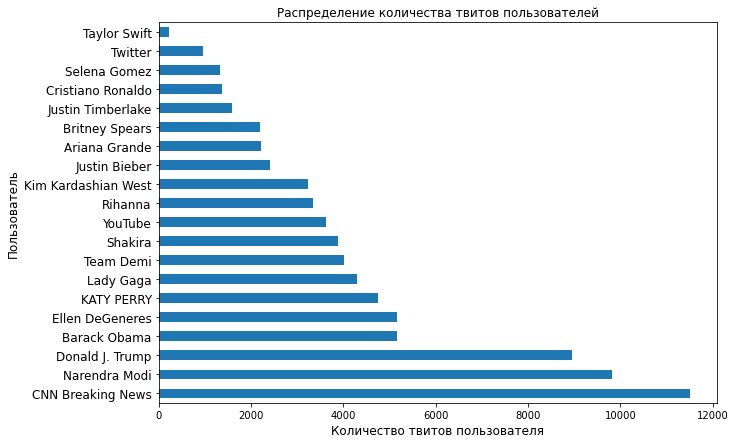

In [350]:
plt.figure(figsize=(10, 7))
df.groupby('name').size().sort_values(ascending=False).plot(kind='barh')
plt.yticks(size=12)
plt.xlabel('Количество твитов пользователя', size=12)
plt.ylabel('Пользователь', size=12)
plt.title('Распределение количества твитов пользователей');

Как следует из диаграммы, в собранной коллекции наименьшая доля твитов приходится на пользователя Taylor Swift, а наибольшая - на пользователей CNN Breaking News, Narendra Modi, Donald J. Trump.

### Слова в твитах

In [332]:
def get_all_words():
    all_words = []
    all_tweets = [tweet for tweet in df['clean_tweet']]
    words_sets_in_tweets = [tweet.split() for tweet in all_tweets]
    for words_set in words_sets_in_tweets:
        for word in words_set:
            all_words.append(word)
    return all_words

In [333]:
all_words = get_all_words()

In [359]:
Counter(all_words).most_common(20)  

[('क', 5714),
 ('u', 5640),
 ('new', 5603),
 ('people', 5549),
 ('president', 5482),
 ('love', 5380),
 ('today', 4274),
 ('thank', 4090),
 ('great', 3921),
 ('us', 3806),
 ('get', 3787),
 ('rt', 3735),
 ('one', 3628),
 ('time', 3381),
 ('र', 3380),
 ('see', 3207),
 ('like', 3145),
 ('day', 3026),
 ('स', 2922),
 ('india', 2887)]

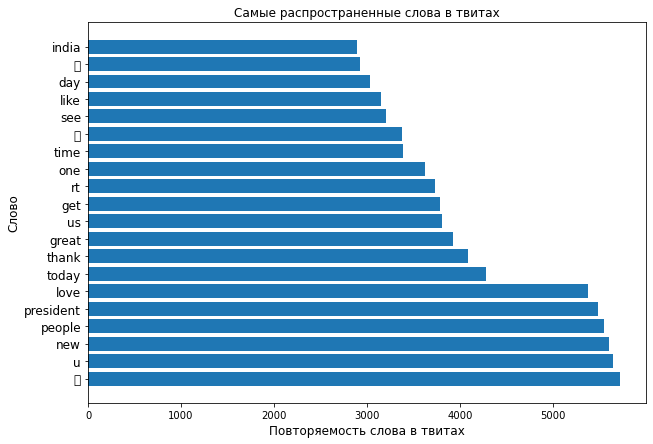

In [352]:
plt.figure(figsize = (10, 7))
plt.barh(*zip(*Counter(all_words).most_common(20)))
plt.yticks(size=12)
plt.xlabel('Повторяемость слова в твитах', size=12)
plt.ylabel('Слово', size=12)
plt.title('Самые распространенные слова в твитах');

Как следует из диаграммы (хотя некоторые символы и не отобразились), в собранной коллекции наибольшее количество (более 4 тысяч) раз встретились слова 'क', 'u', 'new', 'people', 'president', 'love', 'thank'. Слово 'क' часто упоминается в твитах Нарендра Моди - премьер-министра Индии.

### Упоминания других пользователей в твитах

In [276]:
def count_tagged_tweets(df_tags):
    count_tagged_tweets = 0
    for tags_str in df_tags:
        if tags_str != '[]':
            count_tagged_tweets += 1
    return count_tagged_tweets

In [277]:
def get_tags_array(tags_string):
    return re.sub(" +", '', re.sub("\'|\]|\[", '', tags_string)).split(',')

In [278]:
def get_all_tags(df_tags):
    all_tags = []
    for tags_str in df_tags:
        if tags_str != '[]':
            for tag in get_tags_array(tags_str):
                all_tags.append(tag)
    return all_tags

In [283]:
def get_unique_tags(df_tags):
    unique_tags = []
    for tags_str in df_tags:
        if tags_str != '[]':
            for tag in get_tags_array(tags_str):
                if tag not in unique_tags:
                    unique_tags.append(tag)
    return unique_tags 

In [279]:
tweets_with_mentions_count = count_tagged_tweets(df['mentions'])
print("Количество твитов с упоминаниями:", tweets_with_mentions_count)

Количество твитов с упоминаниями: 28209


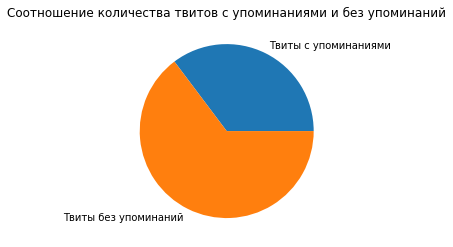

In [335]:
labels = ['Твиты с упоминаниями', 'Твиты без упоминаний']
values = [tweets_with_mentions_count, tweets_count - tweets_with_mentions_count]
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels)
plt.title('Соотношение количества твитов с упоминаниями и без упоминаний')
plt.show()

Как следует из диаграммы, в собранной коллекции примерно две трети твитов без упоминаний других пользователей.

In [280]:
all_mentions = get_all_tags(df['mentions'])

In [282]:
all_mentions_count = len(all_mentions)
print("Количество упоминаний:", all_mentions_count)

Количество упоминаний: 41298


In [284]:
unique_mentions = get_unique_tags(df['mentions'])

In [285]:
unique_mentions_count = len(unique_mentions)
print("Количество уникальных упоминаний:", unique_mentions_count)

Количество уникальных упоминаний: 12194


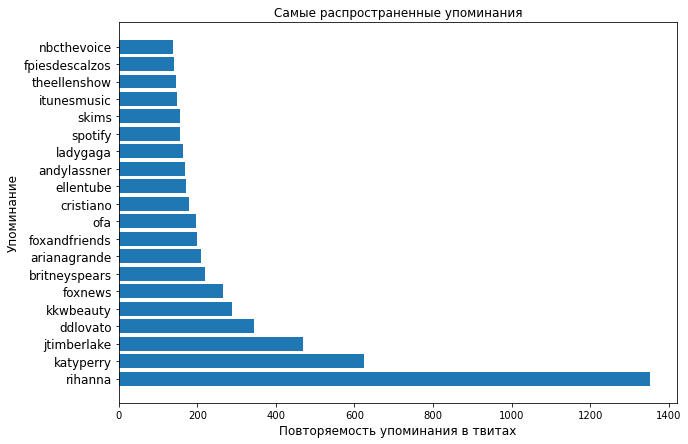

In [356]:
plt.figure(figsize = (10, 7))
plt.barh(*zip(*Counter(all_mentions).most_common(20)))
plt.yticks(size=12)
plt.xlabel('Повторяемость упоминания в твитах', size=12)
plt.ylabel('Упоминание', size=12)
plt.title('Самые распространенные упоминания');

Как следует из диаграммы, в собранной коллекции наибольшее количество раз в твитах отметили следующих пользователей: rihanna, katyperry, jtimberlake.

### Хештеги в твитах

In [288]:
tweets_with_hashtags_count = count_tagged_tweets(df['hashtags'])
print("Количество твитов с хештегами:", tweets_with_hashtags_count)

Количество твитов с хештегами: 25028


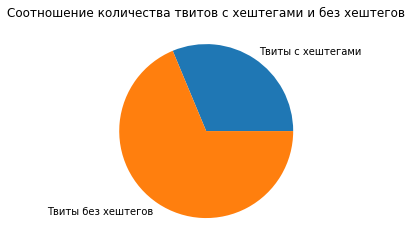

In [313]:
labels = ['Твиты с хештегами', 'Твиты без хештегов']
values = [tweets_with_hashtags_count, tweets_count - tweets_with_hashtags_count]
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels)
plt.title('Соотношение количества твитов с хештегами и без хештегов')
plt.show()

Как следует из диаграммы, в собранной коллекции более, чем две трети твитов без хештегов.

In [289]:
all_hashtags = get_all_tags(df['hashtags'])

In [290]:
all_hashtags_count = len(all_hashtags)
print("Количество хештегов:", all_hashtags_count)

Количество хештегов: 32739


In [291]:
unique_hashtags = get_unique_tags(df['hashtags'])

In [292]:
unique_hashtags_count = len(unique_hashtags)
print("Количество уникальных хештегов:", unique_hashtags_count)

Количество уникальных хештегов: 10670


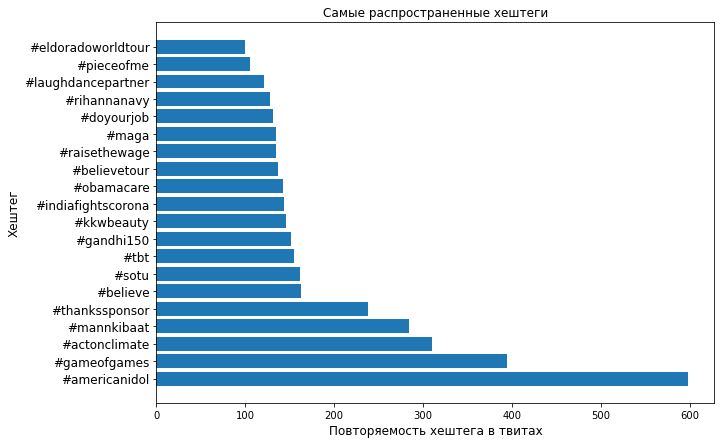

In [357]:
plt.figure(figsize = (10, 7))
plt.barh(*zip(*Counter(all_hashtags).most_common(20)))
plt.yticks(size=12)
plt.xlabel('Повторяемость хештега в твитах', size=12)
plt.ylabel('Хештег', size=12)
plt.title('Самые распространенные хештеги');

Как следует из диаграммы, в собранной коллекции наибольшее количество раз в твитах поставили хештеги: americanidol, gameofgames, actonclimate, mannkibaat, thankssponsor.

### Фотографии в твитах

In [375]:
def count_tweets_with_photos():
    count_tweets_with_photos = 0
    for photos in df['photos']:
        if photos != '[]':
            count_tweets_with_photos += 1
    return count_tweets_with_photos

In [376]:
tweets_with_photos_num = count_tweets_with_photos()
print("Количество твитов с фотографиями:", tweets_with_photos_num)

Количество твитов с фотографиями: 20435


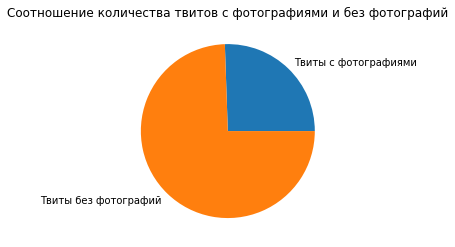

In [377]:
labels = ['Твиты с фотографиями', 'Твиты без фотографий']
values = [tweets_with_photos_num, tweets_count - tweets_with_photos_num]
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels)
plt.title('Соотношение количества твитов с фотографиями и без фотографий')
plt.show()

Как следует из диаграммы, в собранной коллекции примерно четверть твитов с фотографиями, а остальные три четверти - без фотографий.

### Видео в твитах

In [378]:
def count_tweets_with_video():
    count_tweets_with_video = 0
    for video in df['video']:
        if video != 0:
            count_tweets_with_video += 1
    return count_tweets_with_video

In [380]:
tweets_with_video_num = count_tweets_with_video()
print("Количество твитов с видео:", tweets_with_video_num)

Количество твитов с видео: 8430


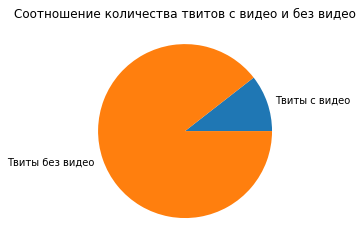

In [382]:
labels = ['Твиты с видео', 'Твиты без видео']
values = [tweets_with_video_num, tweets_count - tweets_with_video_num]
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels)
plt.title('Соотношение количества твитов с видео и без видео')
plt.show()

Как следует из диаграммы, в собранной коллекции лишь малая часть твитов (одна десятая часть) содержит видео. 

### Твиты по дате публикации

In [391]:
df['year'] = df['date'].apply(lambda date: date[:4])

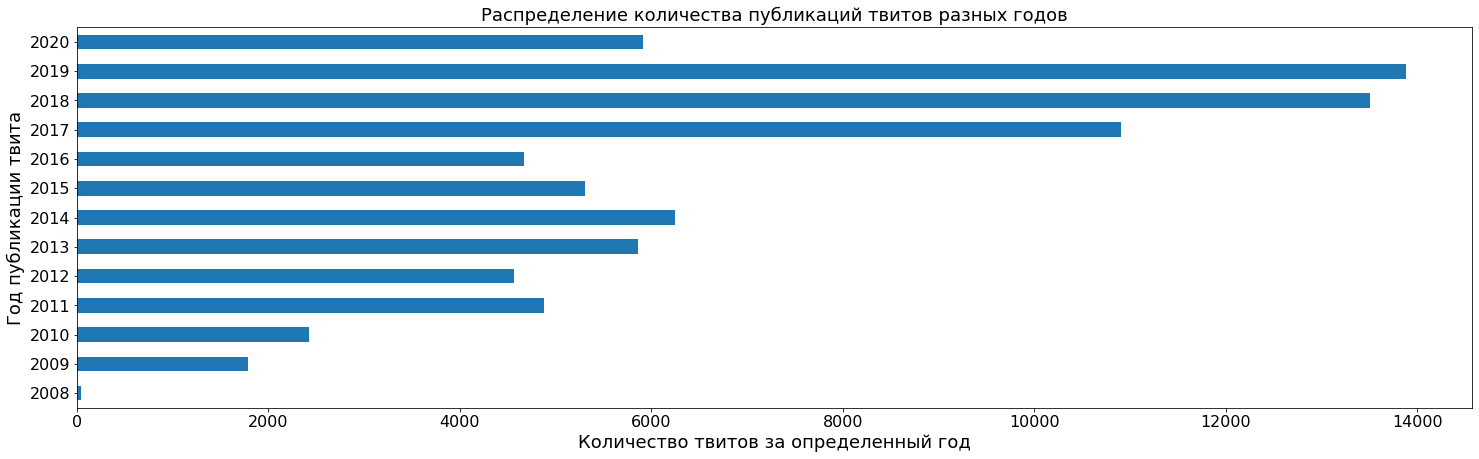

In [416]:
plt.figure(figsize=(25, 7))
df.groupby('year').size().plot(kind='barh')
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel('Количество твитов за определенный год', size=18)
plt.ylabel('Год публикации твита', size=18)
plt.title('Распределение количества публикаций твитов разных годов', size=18);

Как следует из диаграммы, в собранной коллекции больше всего твитов, опубликованных в 2019, 2018, 2017 годах, а меньше всего твитов 2008 года.

In [419]:
df['month'] = df['date'].apply(lambda date: date[5:7])

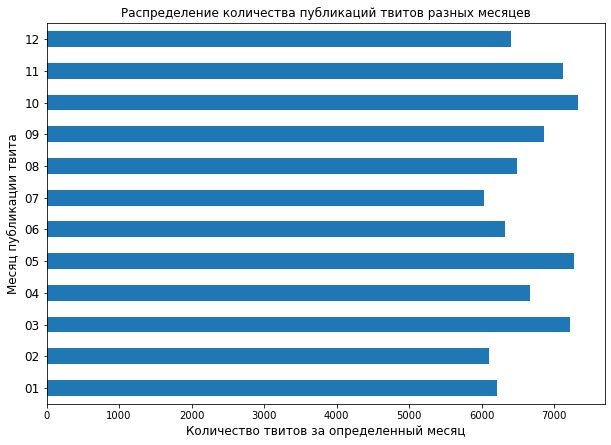

In [425]:
plt.figure(figsize=(10, 7))
df.groupby('month').size().plot(kind='barh')
plt.yticks(size=12)
plt.xlabel('Количество твитов за определенный месяц', size=12)
plt.ylabel('Месяц публикации твита', size=12)
plt.title('Распределение количества публикаций твитов разных месяцев');

Как следует из диаграммы, в собранной коллекции количество публикаций твитов за каждый месяц примерно одинаково.

### Твиты по времени публикации

In [426]:
df['hour'] = df['time'].apply(lambda date: date[:2])

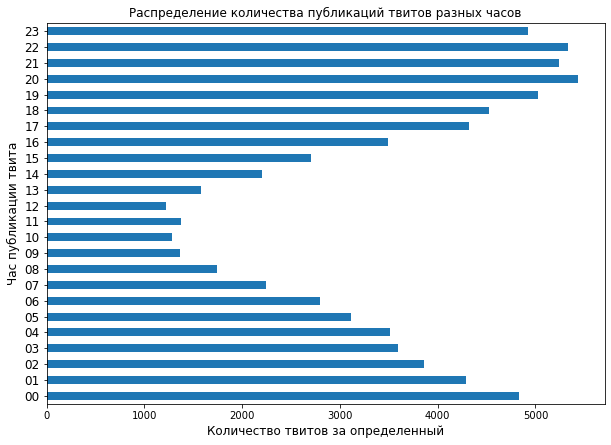

In [428]:
plt.figure(figsize=(10, 7))
df.groupby('hour').size().plot(kind='barh')
plt.yticks(size=12)
plt.xlabel('Количество твитов за определенный', size=12)
plt.ylabel('Час публикации твита', size=12)
plt.title('Распределение количества публикаций твитов разных часов');

Как следует из диаграммы, в собранной коллекции больше всего твитов опубликованы с 19 ч до 1 ч (вечер-ночь) по мск, а меньше всего с 8 ч до 14 ч (утро-день) по мск.

### Среднее количество ответов, лайков, ретвитов за год

In [446]:
years_avg = df[['replies_count','retweets_count','likes_count']].groupby(df['year']).mean()

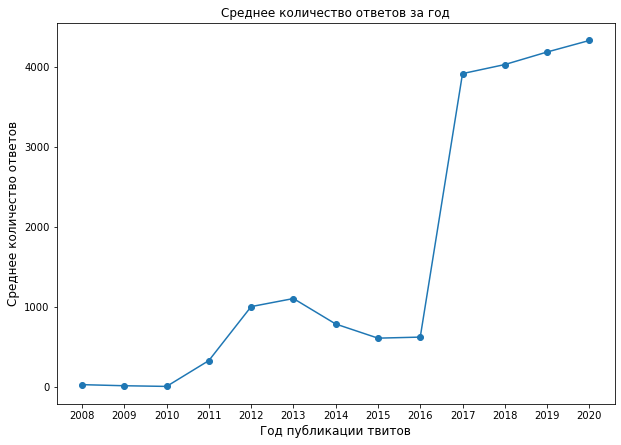

In [447]:
plt.figure(figsize=(10, 7))
plt.plot(years_avg['replies_count'], marker='o')
plt.xlabel('Год публикации твитов', size=12)
plt.ylabel('Среднее количество ответов', size=12)
plt.title('Среднее количество ответов за год');

Как следует из диаграммы, в собранной коллекции усредненное количество ответов на твит за год было примерно 1.3 тысячи до 2017 года, а затем резко возросло до 4 тысяч и продолжает расти. 

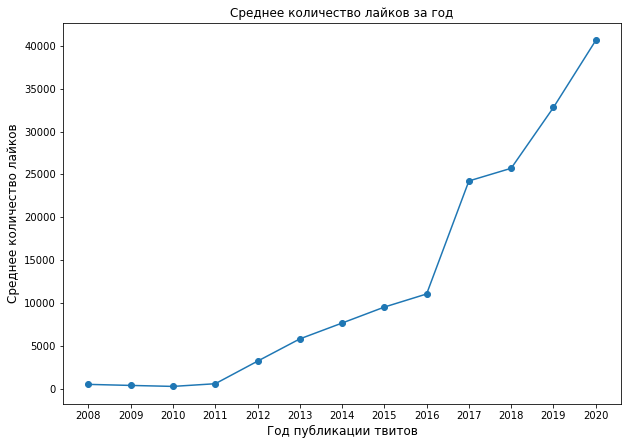

In [448]:
plt.figure(figsize=(10, 7))
plt.plot(years_avg['likes_count'], marker='o')
plt.xlabel('Год публикации твитов', size=12)
plt.ylabel('Среднее количество лайков', size=12)
plt.title('Среднее количество лайков за год');

Как следует из диаграммы, в собранной коллекции усредненное количество лайков на твит за год было примерно 10 тысяч до 2017 года, в 2017 году возросло до 25 тысяч, а в 2020 году превысило отметки в 40 тысяч.

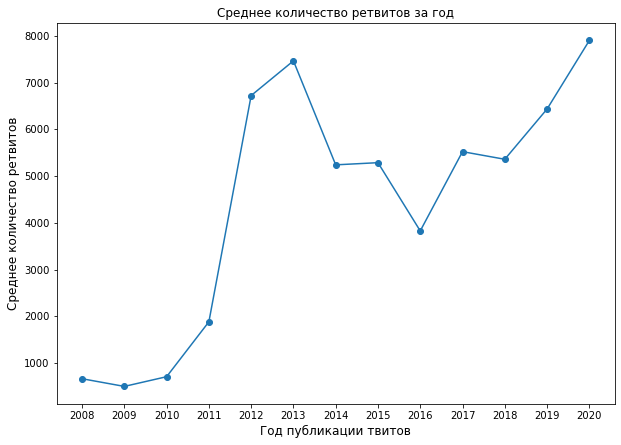

In [449]:
plt.figure(figsize=(10, 7))
plt.plot(years_avg['retweets_count'], marker='o')
plt.xlabel('Год публикации твитов', size=12)
plt.ylabel('Среднее количество ретвитов', size=12)
plt.title('Среднее количество ретвитов за год');

Как следует из диаграммы, в собранной коллекции усредненное количество ретвитов на твит за год было меньше 1 тысячи до 2011 года, возросло до 2 тысяч в 2011 году, дальше был резкий скачок до 7 тысяч в 2012  году, затем был спад, который достиг в 2016 году отметки в 4 тысячи, далее усредненное количество ретвитов за год возрастало и в 2020 году достигло значения 8 тысяч.

### Среднее количество ответов, лайков, ретвитов за месяц

In [440]:
months_avg = df[['replies_count','retweets_count','likes_count']].groupby(df['month']).mean()

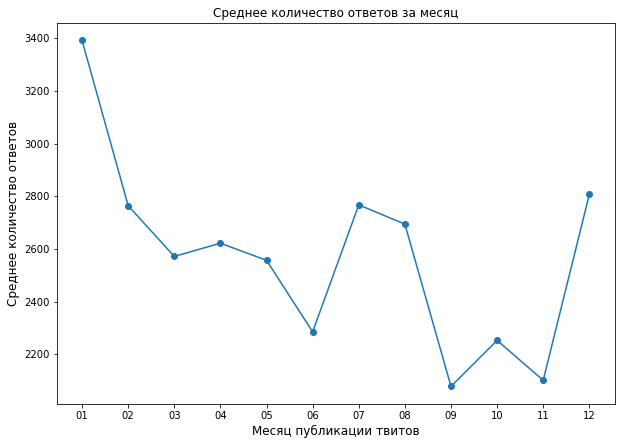

In [443]:
plt.figure(figsize=(10, 7))
plt.plot(months_avg['replies_count'], marker='o')
plt.xlabel('Месяц публикации твитов', size=12)
plt.ylabel('Среднее количество ответов', size=12)
plt.title('Среднее количество ответов за месяц');

Как следует из диаграммы, в собранной коллекции усредненное количество ответов на твит за месяц больше всего в месяце 01 (январь), а меньше всего в месяцах 09 (сентябрь), 11 (ноябрь).

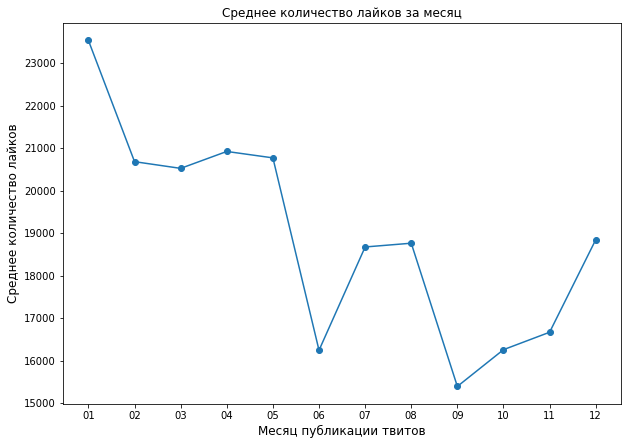

In [444]:
plt.figure(figsize=(10, 7))
plt.plot(months_avg['likes_count'], marker='o')
plt.xlabel('Месяц публикации твитов', size=12)
plt.ylabel('Среднее количество лайков', size=12)
plt.title('Среднее количество лайков за месяц');

Как следует из диаграммы, в собранной коллекции усредненное количество лайков на твит за месяц больше всего в месяце 01 (январь), а меньше всего в месяце 09 (сентябрь).

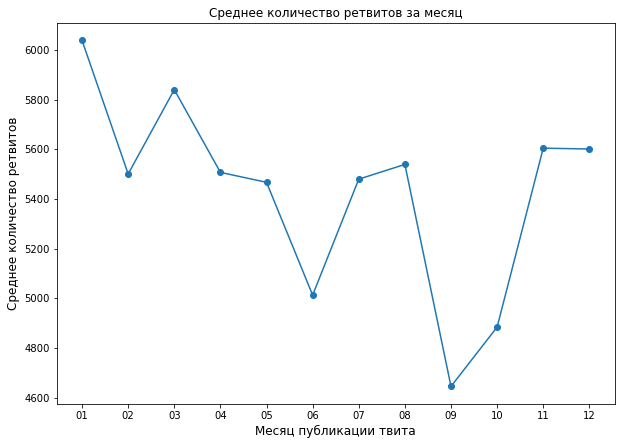

In [445]:
plt.figure(figsize=(10, 7))
plt.plot(months_avg['retweets_count'], marker='o')
plt.xlabel('Месяц публикации твита', size=12)
plt.ylabel('Среднее количество ретвитов', size=12)
plt.title('Среднее количество ретвитов за месяц');

Как следует из диаграммы, в собранной коллекции усредненное количество ретвитов на твит за месяц больше всего в месяцах 01 (январь), 03 (март), а меньше всего в месяцах 09 (сентябрь), 10 (октябрь).